In [6]:
import numpy as np
from utils.draw import draw_strokes

shoes = np.load("/home/joono/MinLab/sketch-photo2seq-torch/datasets/QuickDraw/shoes/npz/sketchrnn_shoes.npz", allow_pickle=True, encoding="latin1")
train, valid, test = shoes["train"], shoes["valid"], shoes["test"]

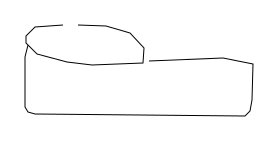

In [7]:
for i in range(1):
    draw_strokes(train[i], 1)

In [8]:
import h5py
import numpy as np

In [9]:
hf = h5py.File("datasets/QMUL/shoes/train_svg_sim_spa_png.h5", 'r')
d = {key: np.array(hf.get(key)) for key in hf.keys()}
hf.close()

In [10]:
d.keys()

dict_keys(['attribute', 'class_id', 'class_name', 'data_offset', 'id', 'image_base_name', 'image_data', 'image_id', 'image_name', 'instance_id', 'png_data'])

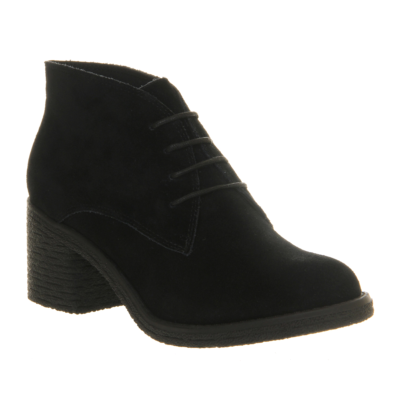

In [11]:
img_base_name = d["image_base_name"][0][0].decode("utf-8")
img_name = img_base_name + ".png"

import os
image = Image.open(os.path.join(".", "datasets", "QMUL", "shoes", "photos", img_name))
image


In [12]:
import cv2
import matplotlib.pyplot as plt

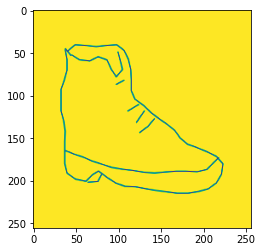

In [12]:
plt.imshow(image)

In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np

from torch.autograd import Variable
from PIL import Image

from model.model import PixEncoder, SeqDecoder
from config import Config

In [20]:
config = Config("./configs/default_config.yml")

pic_enc = PixEncoder()
seq_dec = SeqDecoder(config)

pic_enc.load_state_dict(torch.load("./weights/QMUL/pic_enc_0.pt"))
seq_dec.load_state_dict(torch.load("./weights/QMUL/seq_dec_0.pt"))
seq_dec.training = False

pic_enc.cuda()
seq_dec.cuda()

pic_enc.eval()
seq_dec.eval()

/home/joono/anaconda3/envs/pytorch1_10/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.9 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


SeqDecoder(
  (hc): Linear(in_features=128, out_features=1024, bias=True)
  (lstm): LSTM(133, 512, dropout=0.9)
  (fc_y): Linear(in_features=512, out_features=123, bias=True)
)

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.5, 0.5, 0.5], [1., 1., 1.])
])

In [22]:
input = transform(image).cuda()

sos: torch.Size([1, 1, 5]), batch_init: torch.Size([1, 1, 5]), z_stack: torch.Size([1, 1, 128]), inputs: torch.Size([1, 1, 133])


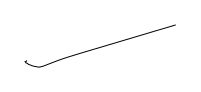

In [25]:
Nmax = 131
batch_size = 1

z, _, _ = pic_enc(input.unsqueeze(0))
        
s = Variable(torch.stack([torch.Tensor([0, 0, 1, 0, 0])]).cuda()).unsqueeze(0)
batch_init = torch.cat([s])
z_stack = torch.stack([z])
inputs = torch.cat([batch_init, z_stack], 2)

print(f"sos: {s.shape}, batch_init: {batch_init.shape}, z_stack: {z_stack.shape}, inputs: {inputs.shape}")

pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell = seq_dec(inputs, z, batch_size)
pen_state = torch.argmax(q)

sketches = []
for i in range(100):
    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell = seq_dec(inputs, z, batch_size, (hidden, cell))
    pen_state = torch.argmax(q)
    q = torch.eye(3)[pen_state]
    mu_s_idx = torch.argmax(pi)
    x, y = mu_x[0, 0, mu_s_idx], mu_y[0, 0, mu_s_idx],
    
    s[0, 0, 0] = x
    s[0, 0, 1] = y
    s[0, 0, 2:] = q
    inputs = torch.cat([s, z_stack], 2)
    
    sketches.append([x.item(), y.item(), pen_state.item()])

sketches = np.array(sketches)
draw_strokes(sketches, 1)

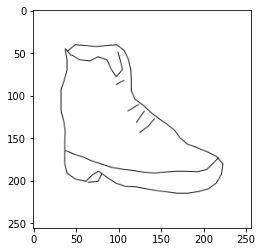

In [39]:
plt.imshow(image, cmap="gray")

In [ ]:
plt.imshow()